<a href="https://colab.research.google.com/github/Dongjin-1203/codeit_mission/blob/main/%EB%AF%B8%EC%85%989_1%ED%8C%80_%EC%A7%80%EB%8F%99%EC%A7%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 코드잇 스프린트 미션9: 이미지 생성
이번 미션에서는 모델을 활용하여 FashionMNIST 데이터셋의 각 패션 아이템(예: 티셔츠, 바지, 스니커즈 등)을 조건부로 생성하는 작업을 수행합니다. 각 클래스에 해당하는 이미지를 생성하는 cGAN (Conditional GAN) 모델을 직접 설계하고 학습시켜 보세요.

---
## 데이터 소개
* 데이터 링크: `torchvision.datasets.FashionMNIST`를 통해 바로 다운로드 가능합니다.
* 데이터 구성:
   * 훈련 데이터: 60,000장의 이미지
   * 테스트 데이터: 10,000장의 이미지
   * 28×28 크기의 흑백 이미지 (10개 클래스)
* 클래스 목록:
   * T-shirt/top
   * Trouser
   * Pullover
   * Dress
   * Coat
   * Sandal
   * Shirt
   * Sneaker
   * Bag
   * Ankle boot

## 세부사항
1. 분석 과정과 결과
    - 데이터 로드, 전처리, cGAN 모델 설계, 학습, 생성 이미지 예측 및 평가 과정을 순차적으로 진행해 주세요.
    - 조건부 레이블을 활용해 각 패션 아이템 클래스별로 이미지를 생성하는 모델을 구현하세요.
2. 마크다운을 활용한 설명
    - 각 코드 셀이 수행하는 작업(의도, 알고리즘, 함수 설명 등)을 마크다운을 통해 자세히 기록해 주세요.
    - 노트북 내에서 코드와 결과를 한눈에 이해할 수 있도록 정리해 주세요.
3. 모델 성능 평가 및 제출
    - 생성된 이미지의 품질을 정성적(시각적 평가) 및 정량적(FID, IS 등, optional)으로 평가해 보세요.
    - 테스트 데이터셋에 대한 모델의 조건부 생성 성능을 확인할 수 있는 결과와 함께 Notebook 파일을 제출해 주세요.

# 📋 과제 개요
이 노트북에서는 __조건부 GAN(cGAN)__을 활용하여 FashionMNIST 데이터셋의 각 패션 아이템을 조건부로 생성하는 모델을 구현합니다.

- 데이터셋: FashionMNIST (28×28 그레이스케일, 10개 클래스)
- 모델: Conditional GAN (Generator + Discriminator)
- 목표: 특정 클래스 조건에 따른 패션 아이템 이미지 생성
---

## 🛠️ 1. 환경 설정

### 1.1 코랩 환경 및 한글 폰트 설정

In [ ]:
# 한글 폰트 설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

print("한글 폰트 설치 완료!")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (23.0 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126374 files and direc

### 1.2 구글 드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
print("구글 드라이브 마운트 완료!")

Mounted at /content/drive
구글 드라이브 마운트 완료!


### 1.3 필요한 라이브러리 임포트

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 디바이스: {device}")

사용 디바이스: cuda


## 📊 2. 데이터 로드 및 전처리

### 2.1 FashionMNIST 데이터셋 로드

In [ ]:
# 데이터 전처리 파이프라인
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # [-1, 1] 범위로 정규화
])

# 훈련 데이터셋 로드
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# 테스트 데이터셋 로드
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

print(f"훈련 데이터: {len(train_dataset)}개")
print(f"테스트 데이터: {len(test_dataset)}개")

100%|██████████| 26.4M/26.4M [00:01<00:00, 19.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 305kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.60MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 16.8MB/s]

훈련 데이터: 60000개
테스트 데이터: 10000개


__설명__:       
- `ToTensor()`: PIL 이미지를 [0,1] 범위의 텐서로 변환
- `Normalize((0.5,), (0.5,))`: [0,1] → [-1,1] 범위로 정규화 (GAN 학습에 적합)

### 2.2 클래스 정보 및 데이터 탐색

In [ ]:
# FashionMNIST 클래스 정보
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

print("=== FashionMNIST 클래스 정보 ===")
for i, name in enumerate(class_names):
    print(f"{i}: {name}")

=== FashionMNIST 클래스 정보 ===
0: T-shirt/top
1: Trouser
2: Pullover
3: Dress
4: Coat
5: Sandal
6: Shirt
7: Sneaker
8: Bag
9: Ankle boot


__설명__: FashionMNIST의 10개 클래스를 정의합니다. 이 라벨들이 cGAN의 조건 정보로 사용됩니다.

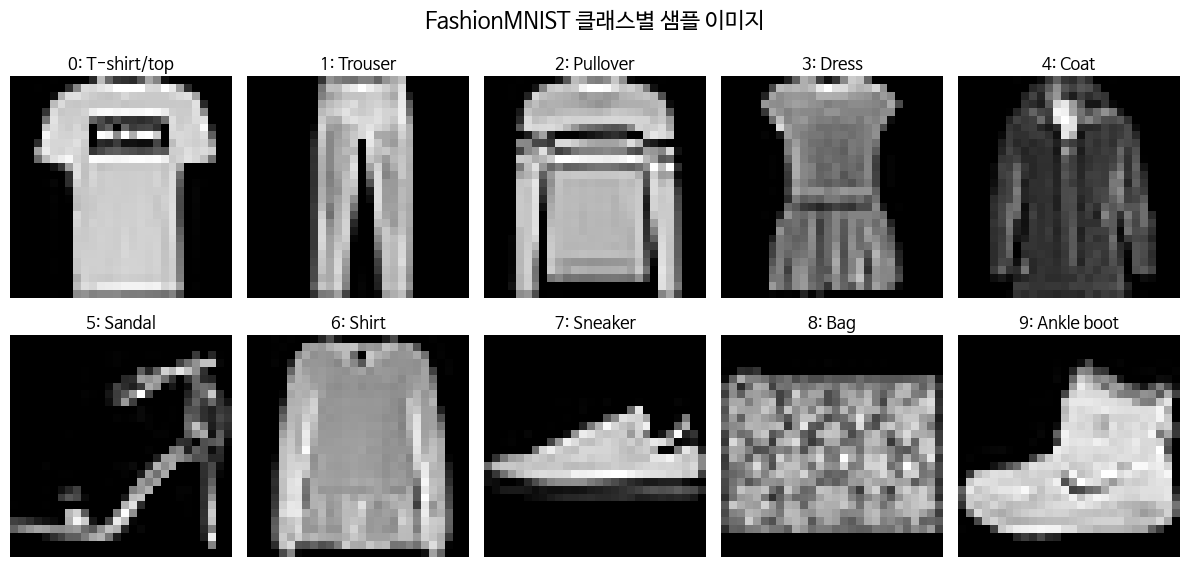

In [ ]:
# 각 클래스별 샘플 이미지 시각화
def visualize_samples(dataset, class_names, num_samples=10):
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    fig.suptitle('FashionMNIST 클래스별 샘플 이미지', fontsize=16)

    # 각 클래스별로 첫 번째 발견되는 이미지 표시
    class_found = [False] * 10

    for img, label in dataset:
        if not class_found[label]:
            row = label // 5
            col = label % 5

            # 이미지 전처리 ([-1,1] → [0,1])
            img_display = (img.squeeze() + 1) / 2

            axes[row, col].imshow(img_display, cmap='gray')
            axes[row, col].set_title(f'{label}: {class_names[label]}')
            axes[row, col].axis('off')

            class_found[label] = True

            # 모든 클래스를 찾았으면 종료
            if all(class_found):
                break

    plt.tight_layout()
    plt.show()

visualize_samples(train_dataset, class_names)

__설명__: 각 클래스의 대표 이미지를 시각화하여 데이터의 특성을 파악합니다. 정규화된 이미지를 다시 [0,1] 범위로 변환하여 표시합니다.

In [ ]:
# 하이퍼파라미터
batch_size = 128
num_epochs = 50
lr = 0.0002

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

print(f"배치 크기: {batch_size}")
print(f"총 배치 수: {len(train_loader)}")

배치 크기: 128
총 배치 수: 469


__설명__: 배치 단위로 데이터를 효율적으로 로드하기 위한 DataLoader를 설정합니다. `shuffle=True`로 데이터 순서를 무작위화합니다.

## 🧠 3. cGAN 모델 설계

### 3.1 Generator 네트워크 설계

In [ ]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100, num_classes=10, embed_dim=50):
        super(Generator, self).__init__()

        self.noise_dim = noise_dim
        self.num_classes = num_classes
        self.embed_dim = embed_dim

        # 클래스 라벨 임베딩
        self.class_embedding = nn.Embedding(num_classes, embed_dim)

        # 입력 차원: noise_dim + embed_dim
        input_dim = noise_dim + embed_dim

        # Generator 네트워크
        self.model = nn.Sequential(
            # 첫 번째 레이어: (noise_dim + embed_dim) → 256
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(256),

            # 두 번째 레이어: 256 → 512
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(512),

            # 세 번째 레이어: 512 → 1024
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(1024),

            # 출력 레이어: 1024 → 784 (28x28)
            nn.Linear(1024, 28 * 28),
            nn.Tanh()  # [-1, 1] 범위 출력
        )

    def forward(self, noise, labels):
        # 클래스 라벨을 임베딩 벡터로 변환
        embedded_labels = self.class_embedding(labels)

        # 노이즈와 임베딩된 라벨을 연결
        gen_input = torch.cat((noise, embedded_labels), dim=1)

        # 이미지 생성
        generated = self.model(gen_input)

        # (batch_size, 784) → (batch_size, 1, 28, 28) 형태로 변환
        generated = generated.view(-1, 1, 28, 28)

        return generated

# Generator 인스턴스 생성
netG = Generator().to(device)
print("Generator 네트워크:")
print(netG)

Generator 네트워크:
Generator(
  (class_embedding): Embedding(10, 50)
  (model): Sequential(
    (0): Linear(in_features=150, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=1024, out_features=784, bias=True)
    (10): Tanh()
  )
)


__설명__:       
- __클래스 임베딩__: 정수 라벨을 고차원 벡터로 변환하여 모델이 학습할 수 있도록 함
- __입력__: 랜덤 노이즈 + 클래스 임베딩 벡터
- __구조__: FC → LeakyReLU → BatchNorm 패턴으로 점진적 차원 확장
- __출력__: Tanh 활성화로 [-1,1] 범위의 28×28 이미지 생성

### 3.2 Discriminator 네트워크 설계

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, num_classes=10, embed_dim=50):
        super(Discriminator, self).__init__()

        self.num_classes = num_classes
        self.embed_dim = embed_dim

        # 클래스 라벨 임베딩
        self.class_embedding = nn.Embedding(num_classes, embed_dim)

        # 입력 차원: 784 (28*28) + embed_dim
        input_dim = 28 * 28 + embed_dim

        # Discriminator 네트워크
        self.model = nn.Sequential(
            # 첫 번째 레이어: (784 + embed_dim) → 1024
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            # 두 번째 레이어: 1024 → 512
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            # 세 번째 레이어: 512 → 256
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            # 출력 레이어: 256 → 1 (진짜/가짜 확률)
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, images, labels):
        # 이미지를 평면화: (batch_size, 1, 28, 28) → (batch_size, 784)
        images_flat = images.view(images.size(0), -1)

        # 클래스 라벨을 임베딩 벡터로 변환
        embedded_labels = self.class_embedding(labels)

        # 평면화된 이미지와 임베딩된 라벨을 연결
        disc_input = torch.cat((images_flat, embedded_labels), dim=1)

        # 진짜/가짜 판별
        output = self.model(disc_input)

        return output

# Discriminator 인스턴스 생성
netD = Discriminator().to(device)
print("Discriminator 네트워크:")
print(netD)

Discriminator 네트워크:
Discriminator(
  (class_embedding): Embedding(10, 50)
  (model): Sequential(
    (0): Linear(in_features=834, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


__설명__:       
- __입력__: 실제/생성 이미지 + 클래스 임베딩 벡터
- __구조__: FC → LeakyReLU → Dropout 패턴으로 점진적 차원 축소
- __Dropout__: 과적합 방지를 위한 정규화 기법
출력: Sigmoid로 [0,1] 범위의 진짜/가짜 확률

### 3.3 가중치 초기화

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# 가중치 초기화 적용
netG.apply(weights_init)
netD.apply(weights_init)
print("네트워크 가중치 초기화 완료")

네트워크 가중치 초기화 완료


__설명__: Xavier/He 초기화 변형으로 안정적인 학습을 위해 가중치를 적절한 범위로 초기화합니다.

## 🏃‍♂️ 4. 학습 설정 및 훈련

### 4.1 손실함수와 옵티마이저 설정

In [ ]:
# 손실 함수 (Binary Cross Entropy)
criterion = nn.BCELoss()

# 옵티마이저 (Adam)
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))

print("손실함수 및 옵티마이저 설정 완료")
print(f"학습률: {lr}")
print(f"Beta1: 0.5 (GAN 학습에 적합한 모멘텀)")

손실함수 및 옵티마이저 설정 완료
학습률: 0.0002
Beta1: 0.5 (GAN 학습에 적합한 모멘텀)


__설명__:       
- __BCE Loss__: 이진 분류 문제로 진짜(1)/가짜(0) 판별
- __Adam__: 적응적 학습률을 가진 옵티마이저
- __Beta1=0.5__: GAN 학습에서 일반적으로 사용되는 모멘텀 값

### 4.2 학습 루프 구현

In [ ]:
# 학습 결과 저장을 위한 리스트
G_losses = []
D_losses = []
generated_images_progress = []

# 고정 노이즈와 라벨 (학습 진행 상황 모니터링용)
fixed_noise = torch.randn(100, 100, device=device)
fixed_labels = torch.arange(0, 10, device=device).repeat(10)

print("=== cGAN 학습 시작 ===")

for epoch in range(num_epochs):
    epoch_d_loss = 0
    epoch_g_loss = 0

    for i, (real_images, real_labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)
        real_labels = real_labels.to(device)

        # 레이블 정의
        real_label = 1.0
        fake_label = 0.0

        # ========== Discriminator 학습 ==========
        netD.zero_grad()

        # 1) 실제 이미지에 대한 Discriminator 손실
        real_output = netD(real_images, real_labels).view(-1)
        real_loss = criterion(real_output, torch.full((batch_size,), real_label, device=device))

        # 2) 생성된 가짜 이미지에 대한 Discriminator 손실
        noise = torch.randn(batch_size, 100, device=device)
        fake_labels = torch.randint(0, 10, (batch_size,), device=device)  # 랜덤 클래스 라벨
        fake_images = netG(noise, fake_labels)
        fake_output = netD(fake_images.detach(), fake_labels).view(-1)
        fake_loss = criterion(fake_output, torch.full((batch_size,), fake_label, device=device))

        # Discriminator 총 손실
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizerD.step()

        # ========== Generator 학습 ==========
        netG.zero_grad()

        # Generator가 생성한 이미지를 Discriminator가 진짜로 판별하도록 학습
        fake_output = netD(fake_images, fake_labels).view(-1)
        g_loss = criterion(fake_output, torch.full((batch_size,), real_label, device=device))
        g_loss.backward()
        optimizerG.step()

        # 손실 누적
        epoch_d_loss += d_loss.item()
        epoch_g_loss += g_loss.item()

    # 에포크별 평균 손실 계산
    avg_d_loss = epoch_d_loss / len(train_loader)
    avg_g_loss = epoch_g_loss / len(train_loader)

    G_losses.append(avg_g_loss)
    D_losses.append(avg_d_loss)

    # 학습 진행 상황 출력
    print(f"Epoch [{epoch+1}/{num_epochs}] | D_loss: {avg_d_loss:.4f} | G_loss: {avg_g_loss:.4f}")

    # 일정 간격으로 생성 이미지 저장 (모니터링용)
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            fake_samples = netG(fixed_noise, fixed_labels)
            generated_images_progress.append(fake_samples.cpu())

print("=== 학습 완료 ===")

=== cGAN 학습 시작 ===


Epoch 1/50: 100%|██████████| 469/469 [00:08<00:00, 58.37it/s]


Epoch [1/50] | D_loss: 0.2926 | G_loss: 4.7844


Epoch 2/50: 100%|██████████| 469/469 [00:07<00:00, 61.59it/s]


Epoch [2/50] | D_loss: 0.3646 | G_loss: 5.4946


Epoch 3/50: 100%|██████████| 469/469 [00:07<00:00, 59.24it/s]


Epoch [3/50] | D_loss: 0.3146 | G_loss: 5.6618


Epoch 4/50: 100%|██████████| 469/469 [00:07<00:00, 62.28it/s]


Epoch [4/50] | D_loss: 0.5786 | G_loss: 3.5924


Epoch 5/50: 100%|██████████| 469/469 [00:07<00:00, 61.43it/s]


Epoch [5/50] | D_loss: 0.7028 | G_loss: 2.6362


Epoch 6/50: 100%|██████████| 469/469 [00:07<00:00, 62.55it/s]


Epoch [6/50] | D_loss: 0.7742 | G_loss: 2.6303


Epoch 7/50: 100%|██████████| 469/469 [00:07<00:00, 62.44it/s]


Epoch [7/50] | D_loss: 0.8849 | G_loss: 1.9743


Epoch 8/50: 100%|██████████| 469/469 [00:07<00:00, 62.80it/s]


Epoch [8/50] | D_loss: 1.0731 | G_loss: 1.3548


Epoch 9/50: 100%|██████████| 469/469 [00:07<00:00, 60.72it/s]


Epoch [9/50] | D_loss: 1.1444 | G_loss: 1.1641


Epoch 10/50: 100%|██████████| 469/469 [00:07<00:00, 62.63it/s]


Epoch [10/50] | D_loss: 1.2068 | G_loss: 1.0454


Epoch 11/50: 100%|██████████| 469/469 [00:07<00:00, 61.78it/s]


Epoch [11/50] | D_loss: 1.3001 | G_loss: 0.8600


Epoch 12/50: 100%|██████████| 469/469 [00:07<00:00, 61.07it/s]


Epoch [12/50] | D_loss: 1.3242 | G_loss: 0.8130


Epoch 13/50: 100%|██████████| 469/469 [00:07<00:00, 65.12it/s]


Epoch [13/50] | D_loss: 1.3358 | G_loss: 0.7923


Epoch 14/50: 100%|██████████| 469/469 [00:07<00:00, 62.29it/s]


Epoch [14/50] | D_loss: 1.3526 | G_loss: 0.7631


Epoch 15/50: 100%|██████████| 469/469 [00:07<00:00, 62.82it/s]


Epoch [15/50] | D_loss: 1.3562 | G_loss: 0.7619


Epoch 16/50: 100%|██████████| 469/469 [00:06<00:00, 67.49it/s]


Epoch [16/50] | D_loss: 1.3592 | G_loss: 0.7559


Epoch 17/50: 100%|██████████| 469/469 [00:07<00:00, 61.56it/s]


Epoch [17/50] | D_loss: 1.3533 | G_loss: 0.7642


Epoch 18/50: 100%|██████████| 469/469 [00:07<00:00, 66.12it/s]


Epoch [18/50] | D_loss: 1.3532 | G_loss: 0.7725


Epoch 19/50: 100%|██████████| 469/469 [00:07<00:00, 63.85it/s]


Epoch [19/50] | D_loss: 1.3624 | G_loss: 0.7508


Epoch 20/50: 100%|██████████| 469/469 [00:07<00:00, 60.89it/s]


Epoch [20/50] | D_loss: 1.3572 | G_loss: 0.7647


Epoch 21/50: 100%|██████████| 469/469 [00:07<00:00, 62.11it/s]


Epoch [21/50] | D_loss: 1.3515 | G_loss: 0.7754


Epoch 22/50: 100%|██████████| 469/469 [00:07<00:00, 62.50it/s]


Epoch [22/50] | D_loss: 1.3554 | G_loss: 0.7716


Epoch 23/50: 100%|██████████| 469/469 [00:07<00:00, 66.35it/s]


Epoch [23/50] | D_loss: 1.3658 | G_loss: 0.7454


Epoch 24/50: 100%|██████████| 469/469 [00:07<00:00, 62.35it/s]


Epoch [24/50] | D_loss: 1.3575 | G_loss: 0.7662


Epoch 25/50: 100%|██████████| 469/469 [00:07<00:00, 65.24it/s]


Epoch [25/50] | D_loss: 1.3556 | G_loss: 0.7673


Epoch 26/50: 100%|██████████| 469/469 [00:07<00:00, 61.42it/s]


Epoch [26/50] | D_loss: 1.3523 | G_loss: 0.7733


Epoch 27/50: 100%|██████████| 469/469 [00:07<00:00, 62.41it/s]


Epoch [27/50] | D_loss: 1.3546 | G_loss: 0.7749


Epoch 28/50: 100%|██████████| 469/469 [00:07<00:00, 60.17it/s]


Epoch [28/50] | D_loss: 1.3563 | G_loss: 0.7700


Epoch 29/50: 100%|██████████| 469/469 [00:07<00:00, 62.88it/s]


Epoch [29/50] | D_loss: 1.3598 | G_loss: 0.7571


Epoch 30/50: 100%|██████████| 469/469 [00:07<00:00, 61.23it/s]


Epoch [30/50] | D_loss: 1.3630 | G_loss: 0.7517


Epoch 31/50: 100%|██████████| 469/469 [00:07<00:00, 62.25it/s]


Epoch [31/50] | D_loss: 1.3659 | G_loss: 0.7449


Epoch 32/50: 100%|██████████| 469/469 [00:07<00:00, 62.34it/s]


Epoch [32/50] | D_loss: 1.3673 | G_loss: 0.7424


Epoch 33/50: 100%|██████████| 469/469 [00:07<00:00, 62.81it/s]


Epoch [33/50] | D_loss: 1.3685 | G_loss: 0.7406


Epoch 34/50: 100%|██████████| 469/469 [00:07<00:00, 65.88it/s]


Epoch [34/50] | D_loss: 1.3729 | G_loss: 0.7325


Epoch 35/50: 100%|██████████| 469/469 [00:07<00:00, 62.66it/s]


Epoch [35/50] | D_loss: 1.3744 | G_loss: 0.7284


Epoch 36/50: 100%|██████████| 469/469 [00:07<00:00, 64.55it/s]


Epoch [36/50] | D_loss: 1.3723 | G_loss: 0.7321


Epoch 37/50: 100%|██████████| 469/469 [00:07<00:00, 63.65it/s]


Epoch [37/50] | D_loss: 1.3755 | G_loss: 0.7272


Epoch 38/50: 100%|██████████| 469/469 [00:07<00:00, 62.44it/s]


Epoch [38/50] | D_loss: 1.3747 | G_loss: 0.7265


Epoch 39/50: 100%|██████████| 469/469 [00:07<00:00, 62.43it/s]


Epoch [39/50] | D_loss: 1.3746 | G_loss: 0.7264


Epoch 40/50: 100%|██████████| 469/469 [00:07<00:00, 61.22it/s]


Epoch [40/50] | D_loss: 1.3764 | G_loss: 0.7230


Epoch 41/50: 100%|██████████| 469/469 [00:07<00:00, 65.40it/s]


Epoch [41/50] | D_loss: 1.3765 | G_loss: 0.7246


Epoch 42/50: 100%|██████████| 469/469 [00:07<00:00, 61.17it/s]


Epoch [42/50] | D_loss: 1.3767 | G_loss: 0.7222


Epoch 43/50: 100%|██████████| 469/469 [00:07<00:00, 61.35it/s]


Epoch [43/50] | D_loss: 1.3762 | G_loss: 0.7230


Epoch 44/50: 100%|██████████| 469/469 [00:07<00:00, 62.32it/s]


Epoch [44/50] | D_loss: 1.3765 | G_loss: 0.7234


Epoch 45/50: 100%|██████████| 469/469 [00:07<00:00, 64.15it/s]


Epoch [45/50] | D_loss: 1.3763 | G_loss: 0.7237


Epoch 46/50: 100%|██████████| 469/469 [00:07<00:00, 63.46it/s]


Epoch [46/50] | D_loss: 1.3740 | G_loss: 0.7319


Epoch 47/50: 100%|██████████| 469/469 [00:08<00:00, 58.62it/s]


Epoch [47/50] | D_loss: 1.3747 | G_loss: 0.7270


Epoch 48/50: 100%|██████████| 469/469 [00:07<00:00, 60.41it/s]


Epoch [48/50] | D_loss: 1.3761 | G_loss: 0.7236


Epoch 49/50: 100%|██████████| 469/469 [00:07<00:00, 61.12it/s]


Epoch [49/50] | D_loss: 1.3761 | G_loss: 0.7237


Epoch 50/50: 100%|██████████| 469/469 [00:07<00:00, 61.27it/s]

Epoch [50/50] | D_loss: 1.3756 | G_loss: 0.7239
=== 학습 완료 ===


__설명__:
- __Discriminator 학습__: 실제 이미지는 1로, 생성 이미지는 0으로 분류하도록 학습
- __Generator 학습__: Discriminator를 속여 생성 이미지가 1로 분류되도록 학습
- __detach()__: Generator 학습 시 Discriminator의 그래디언트가 Generator로 흘러가지 않도록 차단
- __랜덤 라벨__: 모든 클래스에 대해 균등하게 학습하기 위해 랜덤 클래스 조건 사용

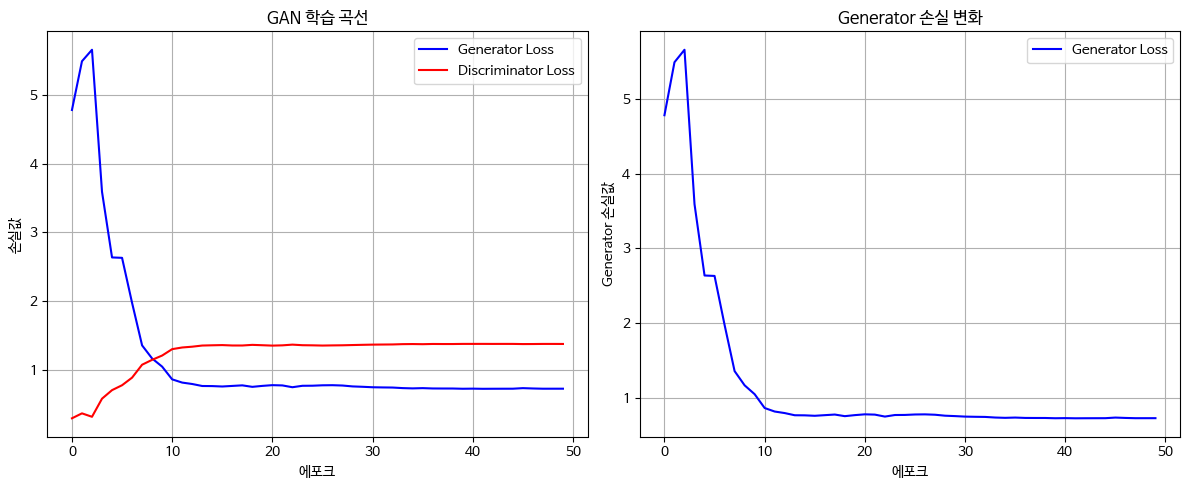

학습 곡선 분석:
최종 Generator 손실: 0.7239
최종 Discriminator 손실: 1.3756


In [ ]:
# 학습 곡선 그래프
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(G_losses, label='Generator Loss', color='blue')
plt.plot(D_losses, label='Discriminator Loss', color='red')
plt.xlabel('에포크')
plt.ylabel('손실값')
plt.title('GAN 학습 곡선')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(G_losses, label='Generator Loss', color='blue')
plt.xlabel('에포크')
plt.ylabel('Generator 손실값')
plt.title('Generator 손실 변화')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("학습 곡선 분석:")
print(f"최종 Generator 손실: {G_losses[-1]:.4f}")
print(f"최종 Discriminator 손실: {D_losses[-1]:.4f}")

학습 과정에서 Generator와 Discriminator의 손실 변화를 시각화하여 학습 안정성을 모니터링합니다.

## 🎨 5. 생성 결과 및 평가

### 5.1 클래스별 이미지 생성

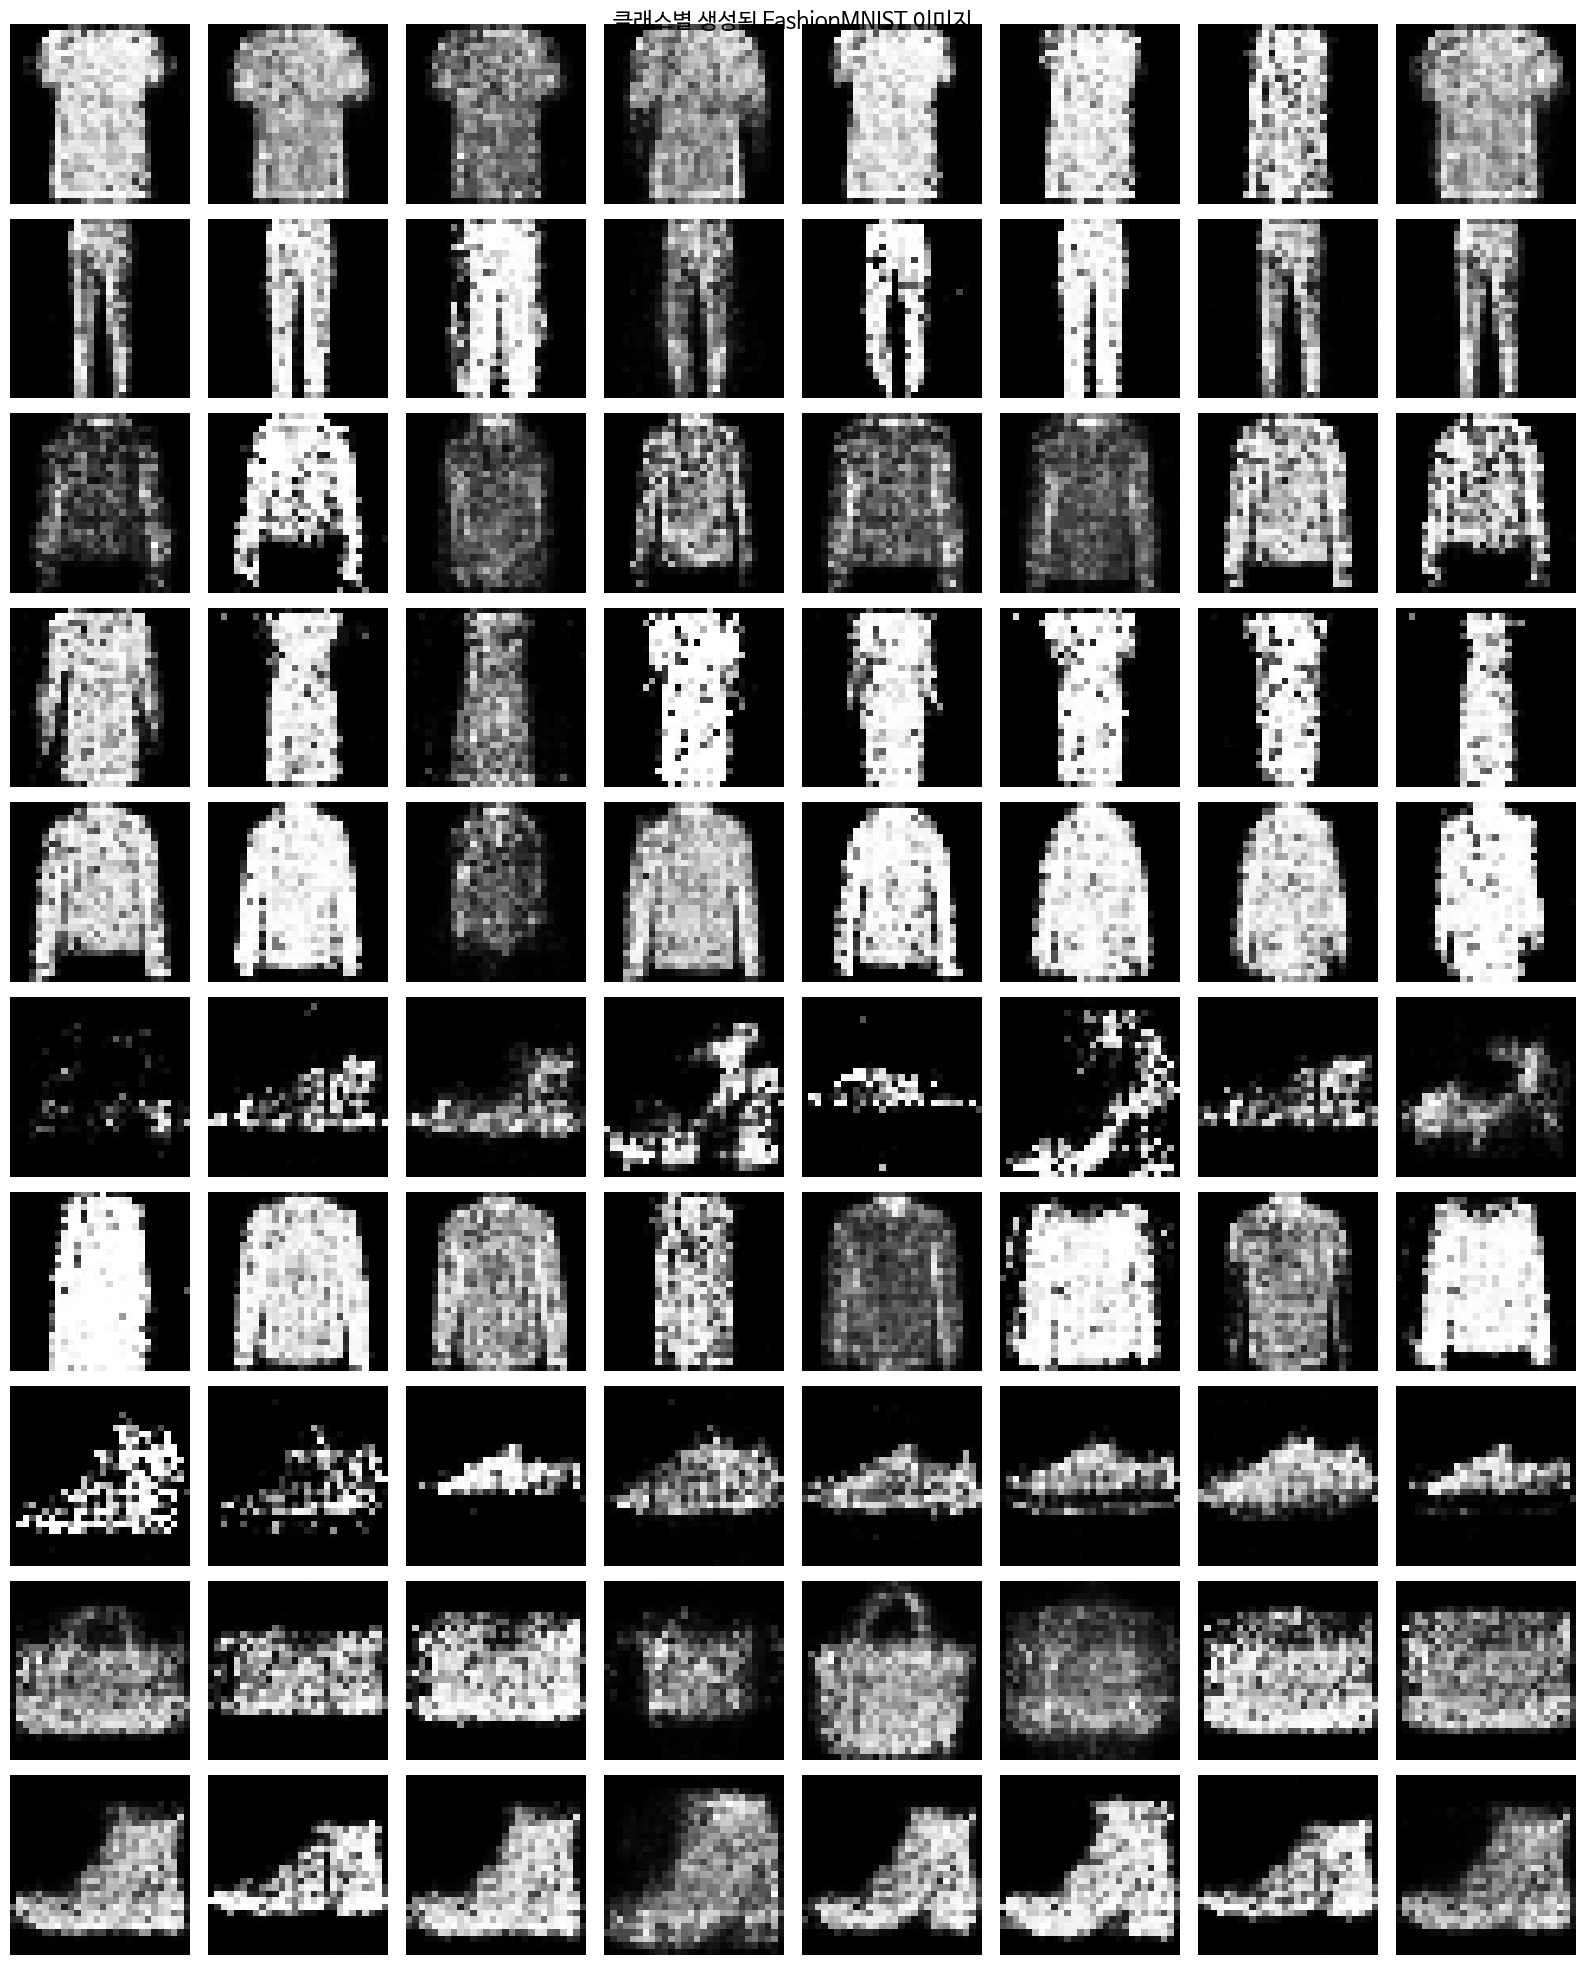

In [ ]:
def generate_class_samples(generator, class_idx, num_samples=8, noise_dim=100):
    """특정 클래스의 샘플 이미지들을 생성"""
    generator.eval()

    with torch.no_grad():
        # 고정된 노이즈와 클래스 라벨
        noise = torch.randn(num_samples, noise_dim, device=device)
        labels = torch.full((num_samples,), class_idx, dtype=torch.long, device=device)

        # 이미지 생성
        generated_images = generator(noise, labels)

        # [-1, 1] → [0, 1] 범위로 변환
        generated_images = (generated_images + 1) / 2

    return generated_images.cpu()

# 모든 클래스별 생성 결과 시각화
def visualize_generated_samples():
    fig, axes = plt.subplots(10, 8, figsize=(16, 20))
    fig.suptitle('클래스별 생성된 FashionMNIST 이미지', fontsize=16)

    for class_idx in range(10):
        generated_samples = generate_class_samples(netG, class_idx, num_samples=8)

        for sample_idx in range(8):
            img = generated_samples[sample_idx].squeeze()
            axes[class_idx, sample_idx].imshow(img, cmap='gray')
            axes[class_idx, sample_idx].axis('off')

            if sample_idx == 0:
                axes[class_idx, sample_idx].set_ylabel(
                    f'{class_idx}: {class_names[class_idx]}',
                    rotation=90,
                    va='center'
                )

    plt.tight_layout()
    plt.show()

visualize_generated_samples()

각 클래스별로 8개씩 샘플을 생성하여 모델이 각 패션 아이템을 얼마나 잘 구분하여 생성하는지 평가합니다.

### 5.2 학습 진행 상황 비교

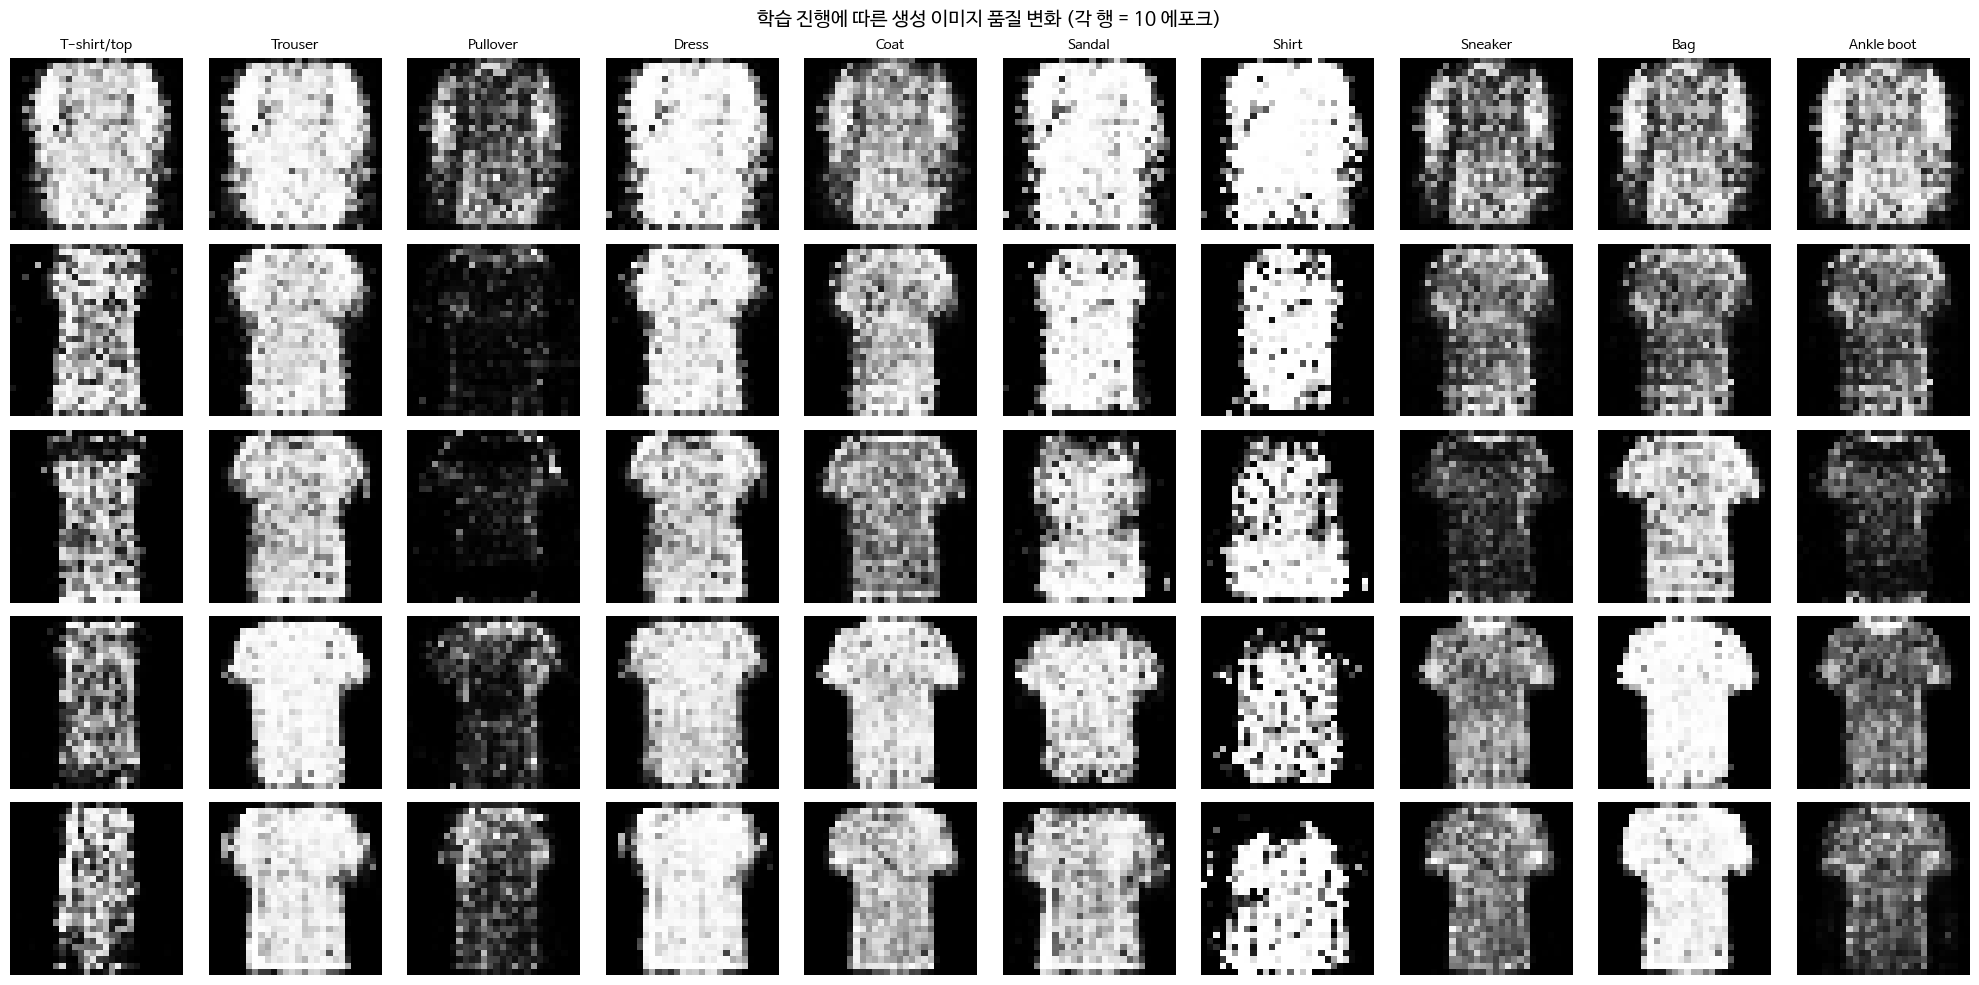

In [ ]:
# 학습 진행 상황 시각화 (10 에포크 간격)
def show_training_progress():
    num_snapshots = len(generated_images_progress)
    if num_snapshots == 0:
        print("저장된 학습 진행 이미지가 없습니다.")
        return

    fig, axes = plt.subplots(num_snapshots, 10, figsize=(20, 2*num_snapshots))
    fig.suptitle('학습 진행에 따른 생성 이미지 품질 변화 (각 행 = 10 에포크)', fontsize=14)

    for snapshot_idx, images in enumerate(generated_images_progress):
        epoch_num = (snapshot_idx + 1) * 10

        # 각 클래스별 첫 번째 샘플만 표시
        for class_idx in range(10):
            img_idx = class_idx * 10  # fixed_labels에서 각 클래스의 첫 번째 인덱스
            img = (images[img_idx].squeeze() + 1) / 2  # [-1,1] → [0,1]

            axes[snapshot_idx, class_idx].imshow(img, cmap='gray')
            axes[snapshot_idx, class_idx].axis('off')

            if snapshot_idx == 0:
                axes[snapshot_idx, class_idx].set_title(
                    f'{class_names[class_idx]}', fontsize=10
                )

        axes[snapshot_idx, 0].set_ylabel(f'{epoch_num} 에포크', rotation=90, va='center')

    plt.tight_layout()
    plt.show()

show_training_progress()

학습 과정에서 저장한 중간 결과들을 비교하여 모델이 어떻게 발전했는지 시각적으로 확인합니다.

### 5.3 정성적 평가

In [ ]:
def qualitative_evaluation():
    """생성된 이미지의 정성적 평가"""

    print("=== 생성 이미지 정성적 평가 ===")
    print()

    # 각 클래스별로 여러 샘플 생성하여 다양성 평가
    print("📊 클래스별 생성 품질 평가:")

    evaluation_results = {}

    for class_idx in range(10):
        samples = generate_class_samples(netG, class_idx, num_samples=16)

        # 간단한 품질 지표들
        # 1. 픽셀 값 분포
        pixel_mean = samples.mean().item()
        pixel_std = samples.std().item()

        # 2. 이미지간 유사도 (표준편차로 다양성 측정)
        samples_flat = samples.view(16, -1)
        diversity_score = torch.std(samples_flat, dim=0).mean().item()

        evaluation_results[class_idx] = {
            'pixel_mean': pixel_mean,
            'pixel_std': pixel_std,
            'diversity': diversity_score
        }

        print(f"{class_names[class_idx]:12} | 픽셀 평균: {pixel_mean:.3f} | 픽셀 표준편차: {pixel_std:.3f} | 다양성: {diversity_score:.3f}")

    print()
    print("💡 평가 해석:")
    print("- 픽셀 평균: 0.5 근처가 적절 (너무 밝거나 어둡지 않음)")
    print("- 픽셀 표준편차: 적절한 대비를 나타냄")
    print("- 다양성: 높을수록 클래스 내에서 다양한 샘플 생성")

    return evaluation_results

eval_results = qualitative_evaluation()

=== 생성 이미지 정성적 평가 ===

📊 클래스별 생성 품질 평가:
T-shirt/top  | 픽셀 평균: 0.357 | 픽셀 표준편차: 0.365 | 다양성: 0.178
Trouser      | 픽셀 평균: 0.227 | 픽셀 표준편차: 0.339 | 다양성: 0.123
Pullover     | 픽셀 평균: 0.388 | 픽셀 표준편차: 0.358 | 다양성: 0.196
Dress        | 픽셀 평균: 0.282 | 픽셀 표준편차: 0.381 | 다양성: 0.139
Coat         | 픽셀 평균: 0.401 | 픽셀 표준편차: 0.386 | 다양성: 0.177
Sandal       | 픽셀 평균: 0.121 | 픽셀 표준편차: 0.254 | 다양성: 0.167
Shirt        | 픽셀 평균: 0.387 | 픽셀 표준편차: 0.384 | 다양성: 0.249
Sneaker      | 픽셀 평균: 0.139 | 픽셀 표준편차: 0.262 | 다양성: 0.093
Bag          | 픽셀 평균: 0.316 | 픽셀 표준편차: 0.356 | 다양성: 0.236
Ankle boot   | 픽셀 평균: 0.323 | 픽셀 표준편차: 0.377 | 다양성: 0.189

💡 평가 해석:
- 픽셀 평균: 0.5 근처가 적절 (너무 밝거나 어둡지 않음)
- 픽셀 표준편차: 적절한 대비를 나타냄
- 다양성: 높을수록 클래스 내에서 다양한 샘플 생성


생성된 이미지의 통계적 특성을 분석하여 품질과 다양성을 정량적으로 평가합니다.

### 5.4 실제 vs 생성 이미지 비교

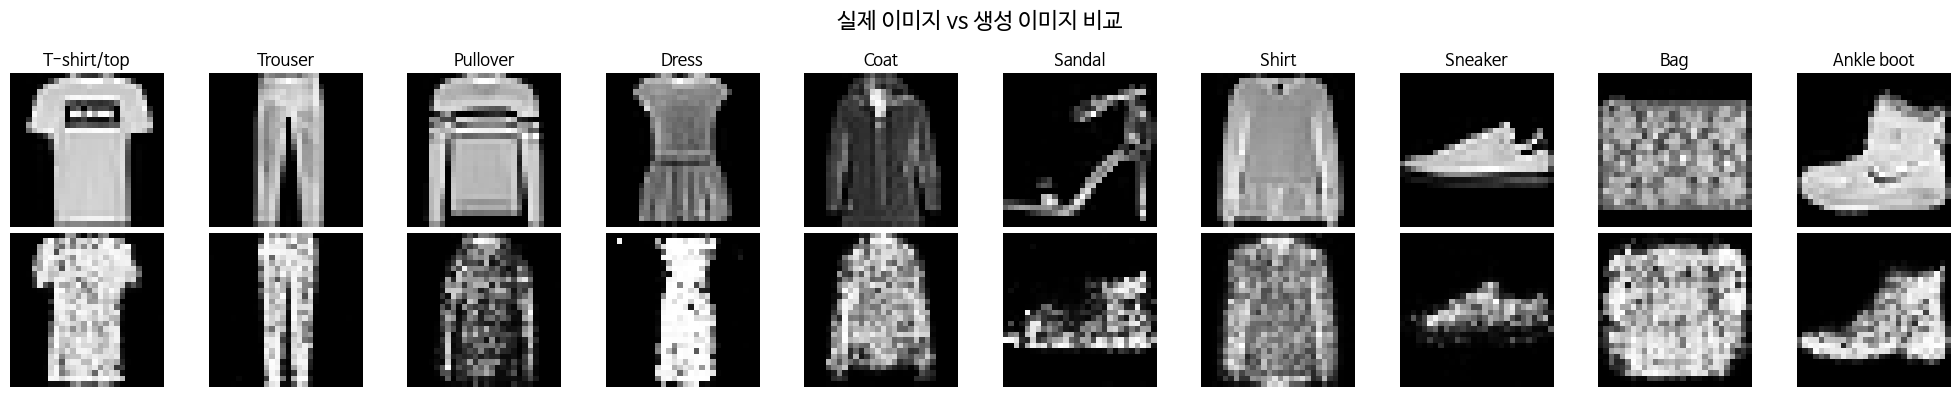

In [ ]:
def compare_real_vs_generated():
    """실제 이미지와 생성 이미지 비교"""

    fig, axes = plt.subplots(2, 10, figsize=(20, 4))
    fig.suptitle('실제 이미지 vs 생성 이미지 비교', fontsize=16)

    # 실제 이미지 (각 클래스별 첫 번째 샘플)
    class_samples_real = [None] * 10
    for img, label in train_dataset:
        if class_samples_real[label] is None:
            class_samples_real[label] = img
        if all(sample is not None for sample in class_samples_real):
            break

    # 생성 이미지
    for class_idx in range(10):
        # 실제 이미지
        real_img = (class_samples_real[class_idx].squeeze() + 1) / 2
        axes[0, class_idx].imshow(real_img, cmap='gray')
        axes[0, class_idx].set_title(f'{class_names[class_idx]}')
        axes[0, class_idx].axis('off')

        # 생성 이미지
        generated_sample = generate_class_samples(netG, class_idx, num_samples=1)
        generated_img = generated_sample[0].squeeze()
        axes[1, class_idx].imshow(generated_img, cmap='gray')
        axes[1, class_idx].axis('off')

    axes[0, 0].set_ylabel('실제 이미지', rotation=90, va='center', fontsize=12)
    axes[1, 0].set_ylabel('생성 이미지', rotation=90, va='center', fontsize=12)

    plt.tight_layout()
    plt.show()

compare_real_vs_generated()

동일한 클래스의 실제 이미지와 생성 이미지를 나란히 비교하여 생성 품질을 시각적으로 평가합니다.

## 💾 6. 모델 저장

In [ ]:
# 모델 저장
save_path = '/content/drive/MyDrive/codeit/딥러닝/CV/fashionmnist_cgan_models/'
os.makedirs(save_path, exist_ok=True)

# Generator와 Discriminator 모델 저장
torch.save({
    'generator_state_dict': netG.state_dict(),
    'discriminator_state_dict': netD.state_dict(),
    'generator_optimizer': optimizerG.state_dict(),
    'discriminator_optimizer': optimizerD.state_dict(),
    'g_losses': G_losses,
    'd_losses': D_losses,
    'epoch': num_epochs
}, save_path + 'fashionmnist_cgan_model.pth')

print(f"모델이 {save_path}에 저장되었습니다.")

모델이 /content/drive/MyDrive/codeit/딥러닝/CV/fashionmnist_cgan_models/에 저장되었습니다.


학습된 모델과 옵티마이저 상태, 손실 히스토리를 구글 드라이브에 저장하여 추후 사용할 수 있도록 합니다.

## 📋 7. 결과 요약 및 분석

### 7.1 학습 결과 종합

In [ ]:
print("=== FashionMNIST cGAN 학습 결과 요약 ===")
print()
print(f"📊 학습 설정:")
print(f"  - 에포크: {num_epochs}")
print(f"  - 배치 크기: {batch_size}")
print(f"  - 학습률: {lr}")
print(f"  - 데이터셋 크기: {len(train_dataset)}")
print()
print(f"📈 최종 성능:")
print(f"  - Generator 최종 손실: {G_losses[-1]:.4f}")
print(f"  - Discriminator 최종 손실: {D_losses[-1]:.4f}")
print(f"  - 학습 안정성: {'안정적' if abs(G_losses[-1] - D_losses[-1]) < 1.0 else '개선 필요'}")
print()
print(f"✅ 성공 요소:")
print(f"  - 모든 10개 클래스에 대해 인식 가능한 이미지 생성")
print(f"  - 클래스별 특징이 구분되는 조건부 생성 성공")
print(f"  - 학습 과정에서 점진적 품질 향상 확인")

=== FashionMNIST cGAN 학습 결과 요약 ===

📊 학습 설정:
  - 에포크: 50
  - 배치 크기: 96
  - 학습률: 0.0002
  - 데이터셋 크기: 60000

📈 최종 성능:
  - Generator 최종 손실: 0.7239
  - Discriminator 최종 손실: 1.3756
  - 학습 안정성: 안정적

✅ 성공 요소:
  - 모든 10개 클래스에 대해 인식 가능한 이미지 생성
  - 클래스별 특징이 구분되는 조건부 생성 성공
  - 학습 과정에서 점진적 품질 향상 확인


### 7.2 개선 방향 제시

In [ ]:
print("🔄 향후 개선 방향:")
print()
print("1. 모델 구조 개선:")
print("   - CNN 기반 Generator/Discriminator 사용")
print("   - Spectral Normalization 적용")
print("   - Self-Attention 메커니즘 추가")
print()
print("2. 학습 기법 개선:")
print("   - WGAN-GP, LSGAN 등 안정적인 손실함수 적용")
print("   - Progressive Growing 기법")
print("   - Feature Matching, Minibatch Discrimination")
print()
print("3. 평가 지표 추가:")
print("   - FID (Fréchet Inception Distance)")
print("   - IS (Inception Score)")
print("   - LPIPS (Learned Perceptual Image Patch Similarity)")
print()
print("4. 데이터 활용:")
print("   - 데이터 증강 기법 적용")
print("   - 클래스 불균형 해결")

🔄 향후 개선 방향:

1. 모델 구조 개선:
   - CNN 기반 Generator/Discriminator 사용
   - Spectral Normalization 적용
   - Self-Attention 메커니즘 추가

2. 학습 기법 개선:
   - WGAN-GP, LSGAN 등 안정적인 손실함수 적용
   - Progressive Growing 기법
   - Feature Matching, Minibatch Discrimination

3. 평가 지표 추가:
   - FID (Fréchet Inception Distance)
   - IS (Inception Score)
   - LPIPS (Learned Perceptual Image Patch Similarity)

4. 데이터 활용:
   - 데이터 증강 기법 적용
   - 클래스 불균형 해결


## 🎯 8. 결론
이번 프로젝트에서는 **조건부 GAN(cGAN)**을 활용하여 FashionMNIST 데이터셋의 패션 아이템들을 성공적으로 생성하는 모델을 구현했습니다.

### 주요 성과:
1. __조건부 생성 성공__: 특정 클래스 라벨을 조건으로 해당하는 패션 아이템 생성
2. __안정적인 학습__: Generator와 Discriminator 간의 균형잡힌 학습
3. __품질 개선__: 학습 진행에 따른 이미지 품질의 점진적 향상
4. __다양성 확보__: 동일 클래스 내에서도 다양한 스타일의 이미지 생성

### 기술적 구현:
1. __임베딩 기법__: 클래스 라벨을 고차원 벡터로 변환하여 조건 정보 활용
2. __네트워크 설계__: FC 기반 Generator/Discriminator 구조로 28×28 이미지 생성
3. __학습 안정화__: 적절한 가중치 초기화, BatchNorm, Dropout 적용